In [1]:
import matplotlib.pylab as plt
import tensorflow as tf
# contain lot of pre-trained models
import tensorflow_hub as hub

import os
import numpy as np
# for datasets
import tensorflow_datasets as tfds 
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [2]:
datasets , info = tfds.load(name = 'beans' ,with_info = True, as_supervised = True, split = ['train', 'test', 'validation'])


In [3]:
info

tfds.core.DatasetInfo(
    name='beans',
    full_name='beans/0.1.0',
    description="""
    Beans is a dataset of images of beans taken in the field using smartphone
    cameras. It consists of 3 classes: 2 disease classes and the healthy class.
    Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated
    by experts from the National Crops Resources Research Institute (NaCRRI) in
    Uganda and collected by the Makerere AI research lab.
    """,
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    data_path='/home/tarun/tensorflow_datasets/beans/0.1.0',
    download_size=171.69 MiB,
    dataset_size=171.63 MiB,
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    splits={
        'test': <SplitInfo num_examples=128, num_shards=1>,
        'train': <SplitInfo num_examples=1034, num_shards=2>,
   

The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


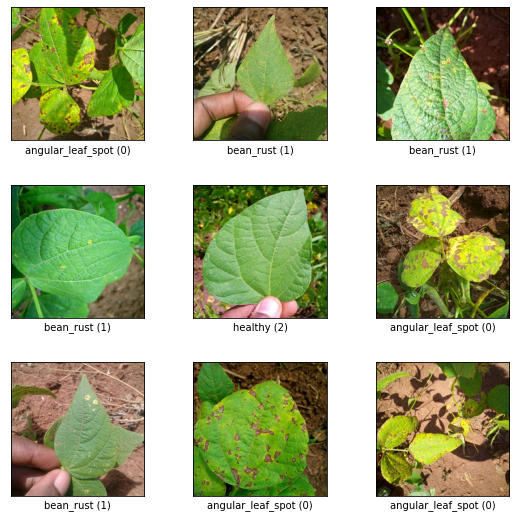

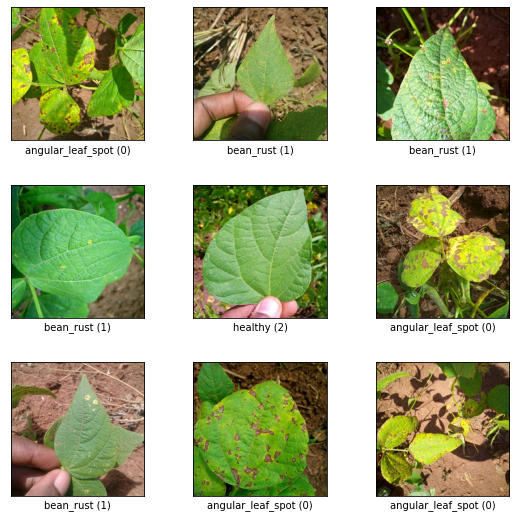

In [4]:
train, info_train = tfds.load(name = 'beans',with_info=True , split = 'test')
tfds.show_examples(info_train, train)

In [5]:
# 
def scale(image, label):
  image = tf.cast(image,tf.float32)
  image/=255.0
  # it resized the image.. 0 -> 000, 1 -> 001
  return tf.image.resize(image,[224,224]),tf.one_hot(label,3)

In [6]:
def get_dataset(batch_size= 32):
  train_dataset_scaled = datasets[0].map(scale).shuffle(1000).batch(batch_size)
  test_dataset_scaled = datasets[1].map(scale).batch(batch_size)
  val_dataset_scaled = datasets[2].map(scale).batch(batch_size)
  return train_dataset_scaled,test_dataset_scaled,val_dataset_scaled



In [7]:
train_dataset,test_dataset,val_dataset=get_dataset()

In [8]:
feature_extract_layer= MobileNetV2(input_shape= (224,224,3))
feature_extract_layer.trainable=False

In [9]:
model = tf.keras.Sequential([feature_extract_layer,
                             tf.keras.layers.Dropout(0.3),
                            tf.keras.layers.Dense(3,activation='softmax') 
                             ])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1000)              3538984   
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3003      
Total params: 3,541,987
Trainable params: 3,003
Non-trainable params: 3,538,984
_________________________________________________________________


In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(),loss= tf.keras.losses.CategoricalCrossentropy
              (from_logits=True),metrics= ['acc'])

In [11]:
hist= model.fit(train_dataset,epochs=3, validation_data=val_dataset)

Epoch 1/3
33/33 [==============================] - 270s 5s/step - loss: 1.0961 - acc: 0.3775 - val_loss: 1.0915 - val_acc: 0.5338
Epoch 2/3
33/33 [==============================] - 45s 1s/step - loss: 1.0911 - acc: 0.5768 - val_loss: 1.0859 - val_acc: 0.6692
Epoch 3/3
33/33 [==============================] - 40s 1s/step - loss: 1.0849 - acc: 0.6489 - val_loss: 1.0801 - val_acc: 0.6692


In [12]:
result = model.evaluate(test_dataset)

4/4 [==============================] - 10s 1s/step - loss: 1.0803 - acc: 0.6406


In [13]:
for f0,f1 in datasets[1].map(scale).batch(200):
  y= np.argmax(f1,axis=1)
  y_pred= np.argmax(model.predict(f0),axis=1)
  print(tf.math.confusion_matrix(labels=y,predictions= y_pred,
                                 num_classes= 3))

tf.Tensor(
[[21 20  2]
 [ 6 30  7]
 [ 0 11 31]], shape=(3, 3), dtype=int32)
